In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")

# from scipy.fft import fft
from numpy.fft import fft,fftfreq

from scipy.stats import f as FDIST
from scipy.stats.distributions import chi2


# Média: 
supondo que média do ruído é zero, se média da distribuição for maior que o limiar, existe sinal.

In [ ]:
def ord_MEDIA(sinal, AMPLITUDES=0):
    # media do sinal espontâneo (ruído)
    # considerando aqui que sinal.shape = (SNR = fixada, amostras/indivíduos, amplitudes)
    ORD =  np.mean(sinal, axis = AMPLITUDES)
    return [sinal, ORD]


# SFT: Spectral F-Test

<img src = "sft.png"/>

In [ ]:
def ord_SFT(sinal, tamanhoLaterais, fSinal=-1, fAmostragem=-1):
    if fAmostragem == -1 and fSinal==-1:
        print('Retornando fft:')
        SINAL = fft(sinal)

        return [SINAL,np.zeros(np.shape(sinal))]

    elif fSinal*fAmostragem <0:
        if fSinal== -1:
            print('Necessário argumento de frequência do SINAL ORIGINAL!')

        if  fAmostragem== -1:
            print('Necessário argumento de frequência do SINAL ORIGINAL!')
        
        return [np.zeros(np.shape(sinal)),np.zeros(np.shape(sinal))]

    else:
        SINAL = fft(sinal)
        #freqs = fftfreq(len(sinal))*fAmostragem #ANTIGO
        # [0:size(Y,1)]*(fs)/(size(s,1));
        freqs = np.arange(0,len(SINAL))*(fAmostragem/len(sinal))

        # central = round(fSinal*len(sinal)/fAmostragem) #ANTIGO
        central = round(fSinal)
        lateralMenor = round(central-tamanhoLaterais/2)
        lateralMaior = round(central+tamanhoLaterais/2)+1       

        DEN =np.abs(SINAL[freqs==fSinal])**2
        SINAL_lateral = np.array(list(SINAL[lateralMenor:central])+list(SINAL[central+1:lateralMaior])) 
        NUM = (1/tamanhoLaterais)*np.sum(np.abs(SINAL_lateral)**2)
        SFT = DEN/NUM
    
    return [SINAL,SFT]

# CSM: Component Synchrony Measure 

<img src = "csm.png"/>

In [ ]:
def ord_CSM(sinal, tamanhoJanela, M,f0=10):
    if len(sinal)-tamanhoJanela*M>=0:
        
        sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

        SINAL = fft(sinal)

        CSMi = (np.sum(np.cos(np.angle(SINAL)),axis=1)/M)**2 + (np.sum(np.sin(np.angle(SINAL)),axis=1)/M)**2

        freqs = np.arange(0,len(SINAL))*(fAmostragem/len(sinal))
        CSM = CSMi[freqs == f0]
        return [SINAL,CSM]
    else:
        print('Erro no número de janelas', tamanhoJanela,'(ou amostras,M =', M,') escolhido.')
        print(len(sinal)-M*tamanhoJanela)
        print('(Retorna 0)')
        return 0 

# MSC: Magnitude-Squared Coherence

<img src = "msc.png"/>

In [ ]:
def ord_MSC(sinal, tamanhoJanela, M):
    # revisar!
    sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

    SINAL = fft(sinal)
    
    MSC = np.abs(np.sum(SINAL,axis=1))**2 / (M*np.sum(np.abs(SINAL)**2,axis=1))

    return [SINAL,MSC]

# Simulação MC

In [ ]:
def monteCarloSimulations(  
    listaSNRs,
    limiar = -9999,
    alpha = 5/100, 
    nSim = 5*10**4, 
    sinal = np.ones((5*10**4,)),
    energiaRuido = 1, 
    ruido = 1*rd.randn(5*10**4,),
    M = 300, 
    tamanhoJanela = 100, 
    tamanhoLaterais = 10,
    fSinal = 10,
    fAmostragem = 100, 
    detector='ord_MEDIA'): 
    # Implementar testes nas entradas!
    # Simulação MC:

    probDetec = np.zeros((len(listaSNRs),1))
    limiares = np.zeros((len(listaSNRs),1))
    
    if limiar == -9999:
        limiarCalculado = False
    else:
        limiarCalculado = True

    sinalX = np.zeros((len(listaSNRs), len(sinal)))
    ORDS = np.zeros((len(listaSNRs), len(sinal)))
    

    print('Simulando')
    for i, SNRi in enumerate(listaSNRs):
        amplitude = 10**((SNRi/20)*(energiaRuido**2))
        # print(amplitude)

        # for sim in range(0,nSim):
        # print(sinal.shape)
        sinalX[i,:] = energiaRuido*rd.randn(len(sinal)) + amplitude*sinal
        # print(sinalX.shape)
        # print(sinalX[i,:])

        if detector=='ord_MEDIA':
            if not(limiarCalculado):
                ruido = energiaRuido*rd.randn(nSim,)
                limiar = np.quantile(ruido, 1-alpha)
                limiarCalculado = True

            [SINAL, ORD] = ord_MEDIA(sinalX[i,:], AMPLITUDES=0)

        elif detector=='ord_SFT':
            if not(limiarCalculado):
                limiar = FDIST.isf(1-alpha, 2, 2*tamanhoLaterais)
                limiarCalculado = True

            
            [SINAL, ORD] = ord_SFT(sinalX[i,:], tamanhoLaterais, fSinal, fAmostragem)
            

        elif detector=='ord_CSM':
            if not(limiarCalculado):
                limiar = chi2.ppf(1-alpha,df=2)/(2*M)
                limiarCalculado = True

            [SINAL, ORD] = ord_CSM(sinalX[i,:], tamanhoJanela, M=M)

        elif detector=='ord_MSC':
            if not(limiarCalculado):
                limiar = 1- alpha**(1/(M-1))
                limiarCalculado = True

            [SINAL, ORD] = ord_MSC(sinalX[i,:], tamanhoJanela, M)
            
        # print(ORD)
        limiar = np.quantile(ORD[:],1-alpha)
        probDetec[i] = np.mean(ORD>limiar)
        limiares[i] = limiar
        ORDS[i,:] = ORD


    print('Pronto')
    return [sinal, ruido, SINAL, ORDS, probDetec, limiares]

# Executando simulações:
## Testando com sinal "CC"

In [ ]:
todasSNRs = np.arange(-20,16,0.1)
numSim = 5*10**3 # 5mil simulações
DC = 5*np.ones((numSim,))

[sinal, ruido, SINAL, ORD, probDetec, limiar] = monteCarloSimulations(listaSNRs = todasSNRs, nSim = numSim,energiaRuido = 0.99, sinal = DC, detector='ord_MEDIA')

In [ ]:
fig,ax = plt.subplots()
sns.histplot(x= ruido, kde= True,ax=fig.axes[0],color='tab:orange')  
sns.histplot(x= sinal, kde= True,ax=fig.axes[0])
plt.axvline(limiar, 0,1,c='r',linestyle='--')
fig.axes[0].set_title('Visualizando limiar')
plt.legend(['Sinal','Ruído','Limiar'])

plt.show()

In [ ]:
pD = pd.DataFrame({'snr': todasSNRs,'prob':probDetec[:,0]})
sns.lineplot(data = pD,x='snr',y='prob');

# Executando simulações:
Testando com sinal senoidal

## MC: SFT

In [ ]:
# TEMPO DE SIMULAÇÃO = 110s
# Parametros:
f = 10
f_s = 100

todasSNRs = np.arange(-20,16,1)
numSim = 5*10**1 # 5mil simulações
M= 300
tamanhoJanela=100
N = M*tamanhoJanela # segundos =tempo * f_s

# Sinal:
N = 30000
t = np.array(range(0, N)) #, endpoint=False)
t = 2*np.pi*f/f_s*t
SINAL = np.sin(t)

# Simulação:
# Erro: tudo deu 1
[sinal, ruido, SINAL, ORDS, probDetec, limiares] = monteCarloSimulations(
    listaSNRs = todasSNRs,
    nSim = numSim,
    energiaRuido = 0.99,
    sinal = SINAL,
    fSinal = f,
    fAmostragem = f_s,
    detector='ord_SFT')

In [ ]:
print(np.quantile(ORDS[iSnr,:],1-5/100))
print(limiares.shape)
print(ORDS.shape)
# print(ORDS[1,:])
esperado = np.zeros(len(todasSNRs))
for ii,SNRi in enumerate(todasSNRs):
    esperado[ii] =  np.quantile(ORDS[ii,:],1-5/100)
print(esperado.shape)
print(limiares)
print(esperado)

In [ ]:
fig, ax = plt.subplots()

# limiares[iSnr]
ax.stem(limiares)
ax.stem(esperado, linefmt='grey', markerfmt='D')

(30000,)
(30000,)
(30000,)
0.0003280403695027004


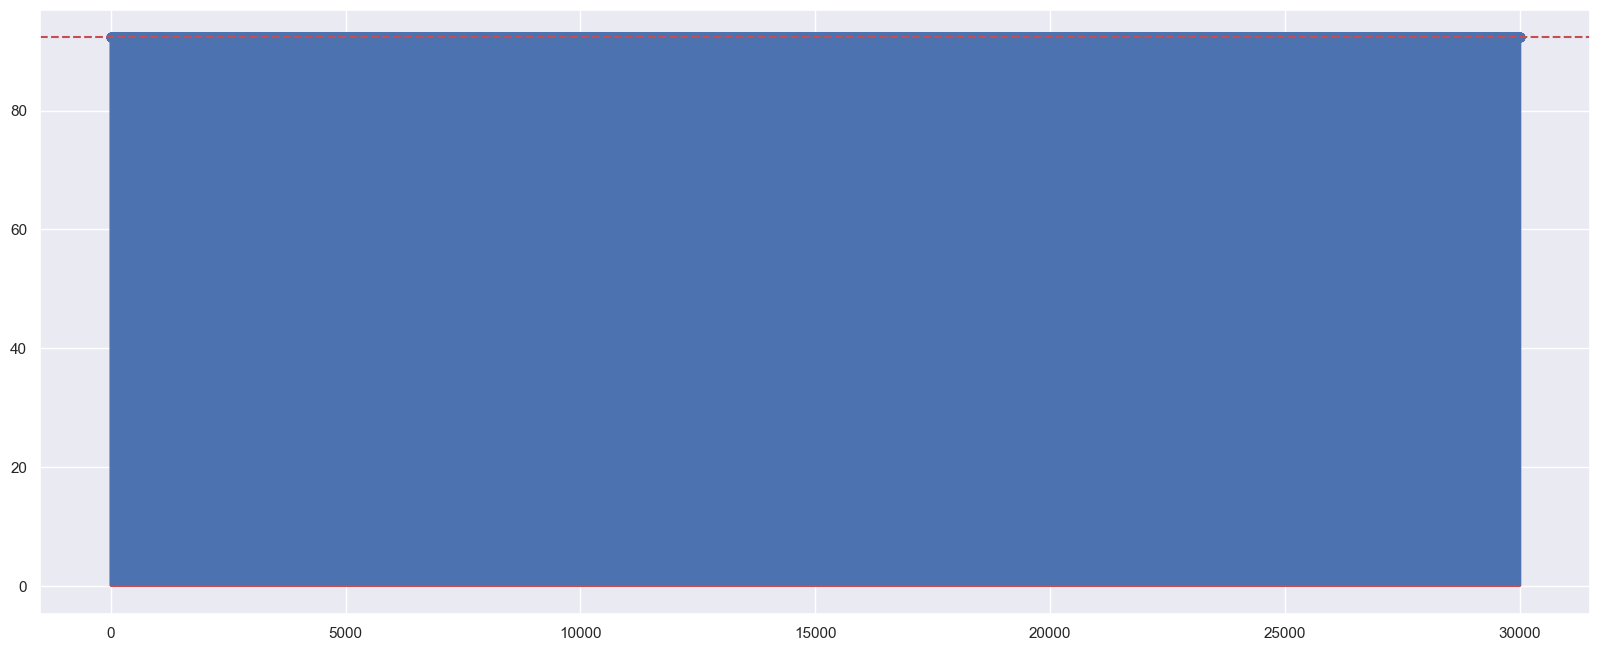

In [144]:
iSnr = 0
print(SINAL.shape)
freqs = np.arange(0,len(SINAL))*(f_s/len(sinal))
print(freqs.shape)
# bins = np.arange(0,len(SINAL))
# print(bins)
print(SINAL.shape)
fig, ax = plt.subplots()

# limiar =  np.quantile(ORDS[iSnr,1,:],1-5/100)
# limiares[iSnr]
ax.stem((ORDS[iSnr,:]))
print(limiar)
plt.axhline(y=limiares[iSnr], color='r', linestyle='--')
# ax.set_xlabel('Frequency in Hertz [Hz]')
# ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
# ax.set_xlim(0, f_s / 2)
# ax.set_ylim(-5, 110);


# print(X[freqs == 10])
# print(np.abs(X[freqs==10]))
# print(np.angle(X[freqs==10]))

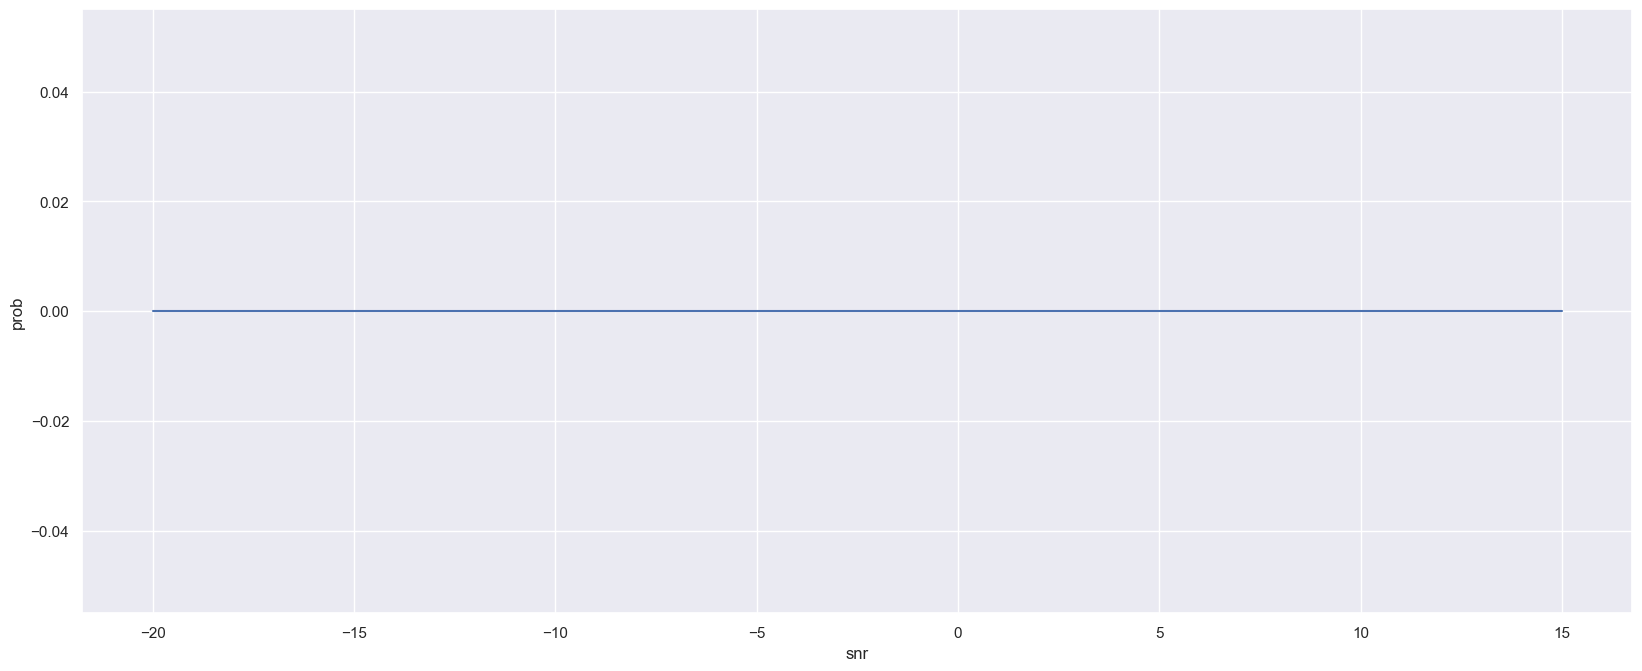

In [145]:
pD = pd.DataFrame({'snr': todasSNRs,'prob':probDetec[:,0]})
sns.lineplot(data = pD,x='snr',y='prob');

## MC: CSM

In [ ]:
# TEMPO DE SIMULAÇÃO 480s
# Parametros:
todasSNRs = np.arange(-20,16,1)
numSim = 5*10**3 # 5mil simulações
M= 300
tamanhoJanela=100
N = M*tamanhoJanela # segundos =tempo * f_s

# Sinal:
N = 30000
t = np.array(range(0, N)) #, endpoint=False)
t = 2*np.pi*f/f_s*t
SINAL = np.sin(t)

# Simulação:
# Erro: ruidosa!
[sinal, ruido, SINAL, ORD, probDetec, limiar] = monteCarloSimulations(
    listaSNRs = todasSNRs,
     nSim = numSim,
     energiaRuido = 0.99,
      sinal = SINAL,
       detector='ord_CSM')

In [ ]:
pD = pd.DataFrame({'snr': todasSNRs,'prob':probDetec[:,0]})
sns.lineplot(data = pD,x='snr',y='prob');

## MC: MSC

In [ ]:
# Paramtros:
todasSNRs = np.arange(-20,16,1)
numSim = 5*10**1 # 5mil simulações
M= 300
tamanhoJanela=100
N = M*tamanhoJanela # segundos =tempo * f_s

# Sinal:
N = 30000
t = np.array(range(0, N)) #, endpoint=False)
t = 2*np.pi*f/f_s*t
SINAL = np.sin(t)

# Erro:
[sinal, ruido, SINAL, ORD, probDetec, limiar] = monteCarloSimulations(
    listaSNRs = todasSNRs,
    nSim = numSim,
    energiaRuido = 0.99,
    sinal = SINAL,
    fSinal = 10,
    fAmostragem = 100,
    detector='ord_MSC')

In [ ]:
pD = pd.DataFrame({'snr': todasSNRs,'prob':probDetec[:,0]})
sns.lineplot(data = pD,x='snr',y='prob');